In [106]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
import random

In [107]:
IMAGE_SIZE=256
BATCH_SIZE=12
CHANNELS=3
EPOCHS=25

## Dataset Import

In [108]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
"Dataset",
   shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5607 files belonging to 7 classes.


In [109]:
class_names=dataset.class_names
class_names

['Go', 'Stop', 'Warning', 'goForward', 'goLeft', 'stopLeft', 'warningLeft']

## Data Visualization

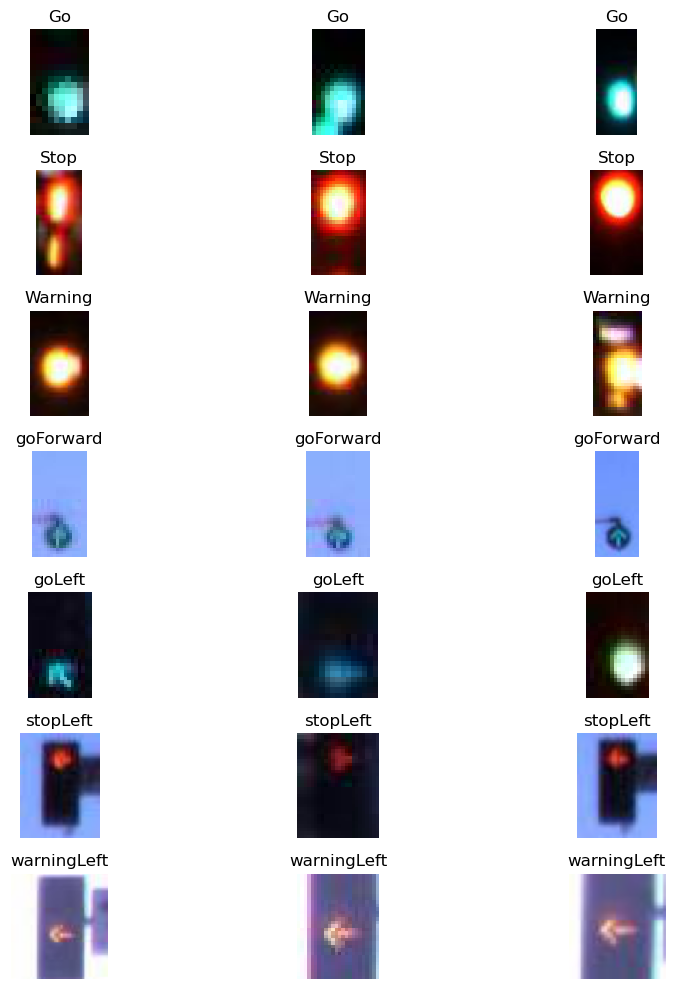

In [115]:
dataset_dir = "Dataset"

# List of classes
classes = ['Go', 'Stop', 'Warning', 'goForward', 'goLeft', 'stopLeft', 'warningLeft']

# Number of images to visualize for each class
num_images_per_class = 3


fig, axes = plt.subplots(len(classes), num_images_per_class, figsize=(10, 10))


for i, class_name in enumerate(classes):
    
    class_dir = os.path.join(dataset_dir, class_name)
    image_files = os.listdir(class_dir)
    
    random.shuffle(image_files)
    image_files = image_files[:num_images_per_class]
    
    for j, image_file in enumerate(image_files):
        img_path = os.path.join(class_dir, image_file)
        img = Image.open(img_path)
        axes[i, j].imshow(img)
        axes[i, j].set_title(class_name)
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

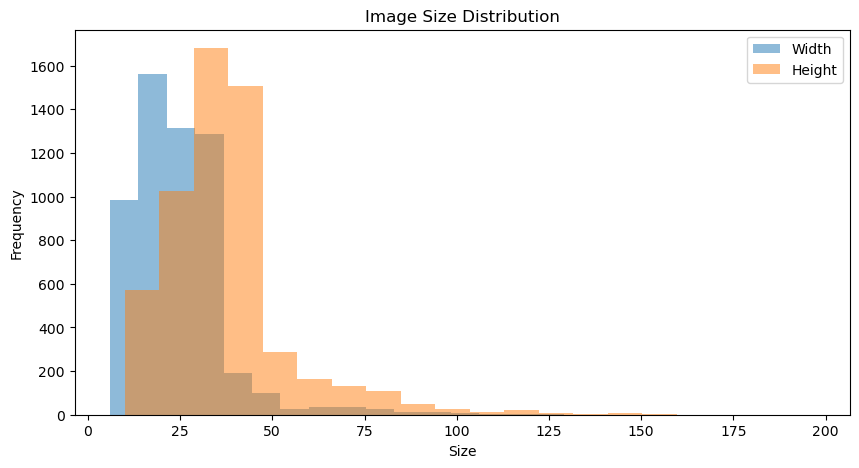

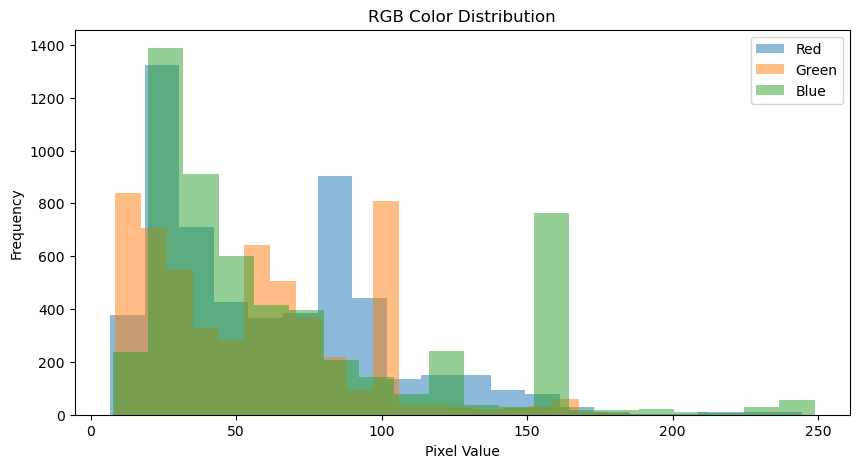

"plt.figure(figsize=(10, 5))\nplt.bar(classes, [np.mean(mean_pixel_intensity[i*len(classes):(i+1)*len(classes)]) for i in range(len(classes))], color='orange')\nplt.title('Mean Pixel Intensity')\nplt.xlabel('Class')\nplt.ylabel('Mean Pixel Intensity')\nplt.xticks(rotation=45)\nplt.show()"

In [100]:
dataset_dir = "Dataset"

# List of classes
classes = ['Go', 'Stop', 'Warning', 'goForward', 'goLeft', 'stopLeft', 'warningLeft']


class_distribution = []
image_sizes = []
mean_pixel_intensity = []


for class_name in classes:
    class_dir = os.path.join(dataset_dir, class_name)
    image_files = os.listdir(class_dir)
    class_distribution.append(len(image_files))
    
    # Get image sizes and mean pixel intensity
    for image_file in image_files:
        img_path = os.path.join(class_dir, image_file)
        img = Image.open(img_path)
        image_sizes.append(img.size)
        mean_pixel_intensity.append(np.mean(np.array(img)))


"""plt.figure(figsize=(10, 5))
plt.bar(classes, class_distribution, color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()"""


image_sizes = np.array(image_sizes)
plt.figure(figsize=(10, 5))
plt.hist(image_sizes[:, 0], bins=20, alpha=0.5, label='Width')
plt.hist(image_sizes[:, 1], bins=20, alpha=0.5, label='Height')
plt.title('Image Size Distribution')
plt.xlabel('Size')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
for i in range(3):
    color_values = [np.mean(np.array(Image.open(os.path.join(dataset_dir, class_name, img_name)))[:, :, i]) for class_name in classes for img_name in os.listdir(os.path.join(dataset_dir, class_name))]
    plt.hist(color_values, bins=20, alpha=0.5, label=['Red', 'Green', 'Blue'][i])
plt.title('RGB Color Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()


"""plt.figure(figsize=(10, 5))
plt.bar(classes, [np.mean(mean_pixel_intensity[i*len(classes):(i+1)*len(classes)]) for i in range(len(classes))], color='orange')
plt.title('Mean Pixel Intensity')
plt.xlabel('Class')
plt.ylabel('Mean Pixel Intensity')
plt.xticks(rotation=45)
plt.show()"""

In [38]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


## Dataset Partition

In [39]:
train_size=0.8
train_ds=dataset.take(54)
test_ds=dataset.skip(54)
val_size=0.1
val_ds=test_ds.take(6)
test_ds=test_ds.skip(6)

In [40]:

def get_dataset_partitions_tf(ds,train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size=len(ds)
    
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
        
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds  = ds.take(train_size)
    val_ds    = ds.skip(train_size).take(val_size)
    test_ds    = ds.skip(train_size).skip(val_size)
    
    
    
    return train_ds, val_ds, test_ds

In [41]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [42]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Defnition

In [43]:
#model that resizes and rescales the input images
resize_and_rescale = tf.keras.Sequential([
    
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),  
    layers.experimental.preprocessing.Rescaling(1.0/255)   
    
])

In [44]:
data_augmentation =  tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
     
])

In [45]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 7

"""
    Activation Functions used
#ReLU (Rectified Linear Unit)
    -> non-linearity
    -> outputs the input value if it's positive and zero otherwise.
#Sigmoid
    ->  for binary classification
"""

model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    # l1
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),  # --> downsample (reduces) the vectors
    # l2
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    # l3
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    # l4
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    # l5
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    # l6
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),  # mulitdimention val to single dimention  

    #-> Connect each neuron with all other neuron in prev layer
    # Dense 1  
    layers.Dense(64, activation='relu'),  
    # Dense 2
    layers.Dense(n_classes, activation='softmax'), # vetors to probabilities 
    
    
])

model.build(input_shape=input_shape)

In [46]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (12, 256, 256, 3)         0         
                                                                 
 sequential_7 (Sequential)   (12, 256, 256, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (12, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (12, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (12, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (12, 62, 62, 64)         0         
 g2D)                                                 

## Model Training

In [47]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [48]:
history = model.fit(
    train_ds,
    epochs=25,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/25
374/374 [==============================] - 116s 301ms/step - loss: 0.5012 - accuracy: 0.8198 - val_loss: 0.6062 - val_accuracy: 0.8225
Epoch 2/25
374/374 [==============================] - 102s 273ms/step - loss: 0.2670 - accuracy: 0.8984 - val_loss: 0.2280 - val_accuracy: 0.9257
Epoch 3/25
374/374 [==============================] - 101s 269ms/step - loss: 0.2395 - accuracy: 0.9062 - val_loss: 0.1737 - val_accuracy: 0.9312
Epoch 4/25
374/374 [==============================] - 104s 277ms/step - loss: 0.2042 - accuracy: 0.9243 - val_loss: 0.1799 - val_accuracy: 0.9330
Epoch 5/25
374/374 [==============================] - 105s 281ms/step - loss: 0.1908 - accuracy: 0.9292 - val_loss: 0.1802 - val_accuracy: 0.9185
Epoch 6/25
374/374 [==============================] - 105s 280ms/step - loss: 0.1808 - accuracy: 0.9272 - val_loss: 0.2367 - val_accuracy: 0.9112
Epoch 7/25
374/374 [==============================] - 103s 276ms/step - loss: 0.1690 - accuracy: 0.9346 - val_loss: 0.1230 -

In [49]:
model.save('Version_2.0.h5')
print('Model Saved!')

Model Saved!


## Training Results

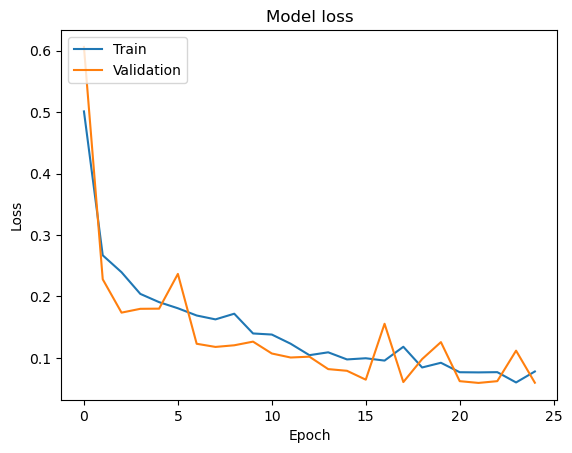

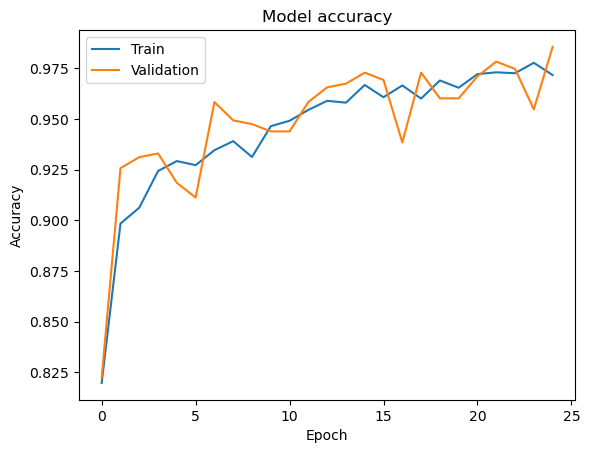

In [116]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [50]:
savedModel1 = load_model('Version_2.0.h5')

In [117]:
data1= tf.keras.preprocessing.image_dataset_from_directory(
"Test_Dataset",
   shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names1 = data1.class_names


Found 684 files belonging to 7 classes.


In [118]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
  
    
    predicted_class = class_names [np.argmax(predictions[0])] # argmax -> [0.1, 0.8, 0.3, 0.6] - will give max agr value -> 0.8
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence 

## Model Testing

1/1 [==============================] - 0s 25ms/step


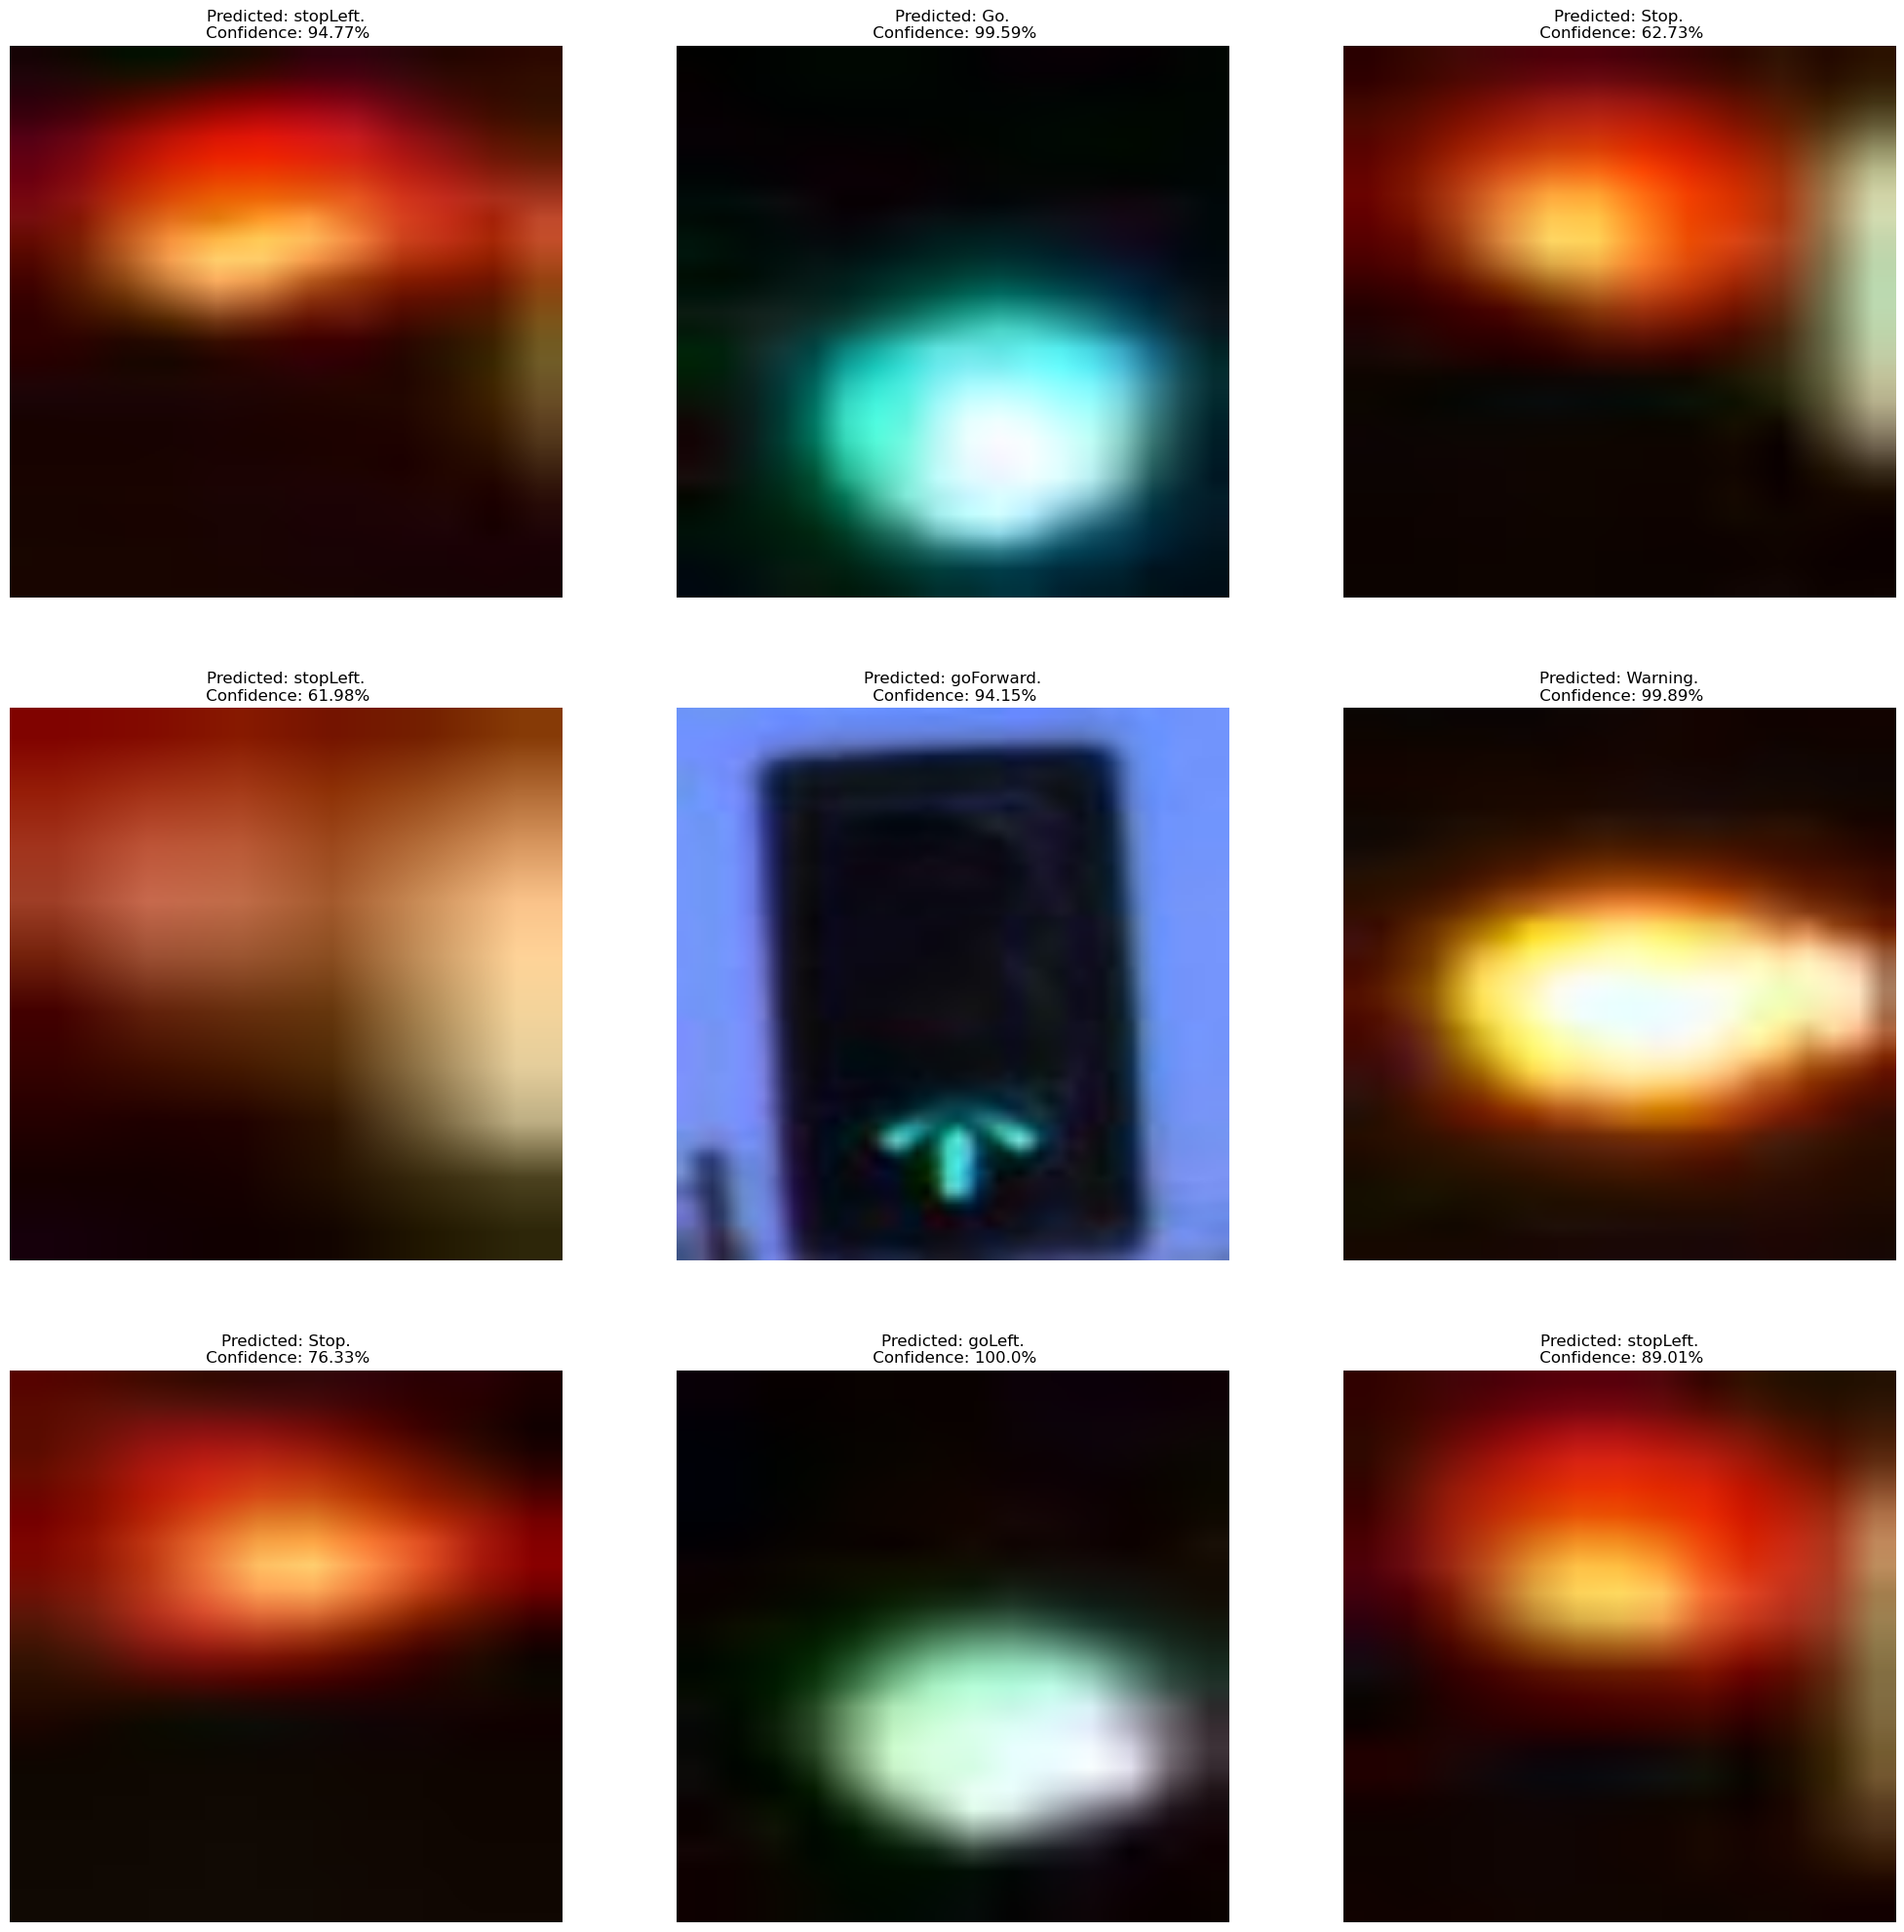

In [119]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

plt.figure(figsize=(25,25))
for images, labels in data1.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(savedModel1, images[i].numpy()) 
        actual_class = class_names[labels[i]]
        
        #plt.title(f"Actual : {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.title(f"Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [97]:
img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
img_array = tf.expand_dims(img_array, 0) # Creating  a batch
    
predictions = model.predict(img_array)
  
predicted_class = class_names [np.argmax(predictions[0])]
confidence = round(100 * (np.max(predictions[0])), 2)

1/1 [==============================] - 0s 44ms/step
